In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=d100200bedb8f8f6e8c2035a8c17268e3dcbdf199b93710558b90f2f241ee609
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import yfinance
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [0]:
portfolio_composition = [('MSFT',0.5),('AAPL',0.2),('GOOG',0.3)]

returns = pd.DataFrame({})


In [0]:
for t in portfolio_composition:
  name = t[0]
  ticker = yfinance.Ticker(name)
  data = ticker.history(interval="1d",start="2010-01-01",end="2019-12-31")
  data['return_%s' % (name)] = data['Close'].pct_change(1)

  returns = returns.join(data[['return_%s' % (name)]],how="outer").dropna()

In [0]:
returns

,return_MSFT,return_AAPL,return_GOOG
Date,,,
2010-01-05,0.000412,0.001507,-0.004388
2010-01-06,-0.006173,-0.015801,-0.025223
2010-01-07,-0.010352,-0.001911,-0.023268
2010-01-08,0.007113,0.006894,0.013347
2010-01-11,-0.012879,-0.009129,-0.001534
...,...,...,...
2019-12-23,0.000000,0.016321,-0.000556
2019-12-24,-0.000191,0.000953,-0.003914
2019-12-26,0.008219,0.019817,0.012534


In [0]:
def simulate_returns(historical_returns,forecast_days):
  return historical_returns.sample(n = forecast_days, 
                                   replace = True).reset_index(drop = True)

In [0]:
simulate_returns(returns['return_AAPL'],1000)

0     -0.003887
1     -0.000676
2     -0.005246
3     -0.010805
4      0.058233
         ...   
995   -0.004859
996    0.010595
997    0.005688
998    0.019051
999   -0.031290
Name: return_AAPL, Length: 1000, dtype: float64

In [0]:
def simulate_portfolio(historical_returns,composition,forecast_days):
  result = 0
  for t in composition:
    name,weight = t[0],t[1]
    s = simulate_returns(historical_returns['return_%s' % (name)], forecast_days)
    result = result + s * weight
  
  return(result)


In [0]:
simulate_portfolio(returns,portfolio_composition,10)

0    0.009355
1    0.001613
2    0.004744
3    0.000073
4   -0.003771
5   -0.006820
6    0.003886
7    0.013020
8    0.030238
9    0.003929
dtype: float64

In [0]:
def simulate_modified_returns(historical_returns,forecast_days,correct_mean_by):
  h = historical_returns.copy()

  new_series = h + correct_mean_by

  return new_series.sample(n=forecast_days,replace=True).reset_index(drop=True)

In [0]:
def simulate_modified_portfolio(historical_returns,composition,forecast_days):
  result = 0
  for t in composition:
    name,weight,correction = t[0],t[1],t[2]
    s = simulate_modified_returns(historical_returns['return_%s' % (name)], forecast_days,correction)
    result = result + s * weight
  
  return(result)


In [0]:
def simulation(historical_returns,composition,forecast_days,n_iterations):
  simulated_portfolios = None

  for i in range(n_iterations):
    sim = simulate_modified_portfolio(historical_returns,composition,forecast_days)

    sim_port = pd.DataFrame({'returns_%d' % (i) : sim})

    if simulated_portfolios is None:
      simulated_portfolios = sim_port
    else:
      simulated_portfolios = simulated_portfolios.join(sim_port)
    
  return simulated_portfolios

# Simulation with corrections

In [0]:
returns.mean(axis=0)

return_MSFT    0.000845
return_AAPL    0.001085
return_GOOG    0.000696
dtype: float64

In [0]:
portfolio_composition = [('MSFT', 0.5,-0.0001), ('AAPL', 0.2,-0.001), ('GOOG', 0.3,-0.0005)]

In [0]:
forecast_days = 20
n_iterations = 200

In [0]:
simulated_portfolios = simulation(returns,portfolio_composition,forecast_days,n_iterations)

In [0]:
simulated_portfolios.head()

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,returns_10,returns_11,returns_12,returns_13,returns_14,returns_15,returns_16,returns_17,returns_18,returns_19,returns_20,returns_21,returns_22,returns_23,returns_24,returns_25,returns_26,returns_27,returns_28,returns_29,returns_30,returns_31,returns_32,returns_33,returns_34,returns_35,returns_36,returns_37,returns_38,returns_39,...,returns_160,returns_161,returns_162,returns_163,returns_164,returns_165,returns_166,returns_167,returns_168,returns_169,returns_170,returns_171,returns_172,returns_173,returns_174,returns_175,returns_176,returns_177,returns_178,returns_179,returns_180,returns_181,returns_182,returns_183,returns_184,returns_185,returns_186,returns_187,returns_188,returns_189,returns_190,returns_191,returns_192,returns_193,returns_194,returns_195,returns_196,returns_197,returns_198,returns_199
0,-0.001309,0.009051,0.003752,0.006321,0.010656,0.003088,0.015518,0.008354,-0.018625,-0.003609,-0.002058,-0.004679,-0.003066,-0.016827,0.006909,-0.003618,0.011895,-0.006720,-0.004782,-0.007936,-0.009582,-0.010635,0.011638,-0.023319,0.000983,-0.000160,-0.014770,0.002514,-0.013678,-0.018882,-0.010320,0.016416,-0.008037,0.009752,0.002019,-0.033233,0.000358,0.002404,-0.000695,-0.001841,...,-0.007925,0.043795,0.016628,-0.002413,0.000283,0.003969,0.007820,-0.004147,0.022642,-0.003523,-0.022652,0.005523,-0.019103,-0.016854,-0.004310,0.002850,4.034695e-03,-0.013363,0.015274,0.008163,-0.004055,0.011053,-0.015848,0.009971,0.009459,0.007728,0.001476,0.000371,0.007528,0.005388,0.003638,-0.008826,0.036300,0.005611,-0.006915,-0.001511,0.011916,-0.011778,-0.005731,0.003837
1,-0.002089,-0.008966,0.005271,0.006250,-0.003797,-0.005805,-0.000216,0.006820,0.000383,-0.010654,0.002307,-0.009357,0.002722,0.016736,0.006107,0.003352,0.017181,-0.005503,-0.006055,0.010284,0.001043,-0.003288,-0.000192,0.007946,-0.007555,0.005959,0.009091,-0.000953,0.005976,0.001816,-0.015710,-0.004950,0.007785,0.009515,0.001791,-0.001596,-0.011794,0.001819,-0.002810,-0.001986,...,0.012707,0.000887,-0.008303,0.014803,0.009128,-0.006166,0.008220,0.003502,0.004723,-0.003110,-0.006706,0.003352,-0.006852,0.001958,-0.001344,0.010659,-5.124692e-07,0.009344,-0.000299,0.003172,0.006960,-0.013112,0.014759,0.011751,0.003177,0.005424,0.005274,-0.006595,-0.003016,0.002362,0.011789,0.000624,-0.004229,0.009459,-0.006305,0.007037,-0.010265,0.001787,0.015894,-0.008914
2,0.003633,-0.018941,0.008386,0.018492,-0.006935,-0.003875,0.005577,-0.000202,0.011739,0.000558,0.005041,0.005472,0.002227,0.010795,-0.000776,-0.004140,0.009519,-0.003413,-0.016297,-0.005164,-0.007873,-0.001605,0.007057,0.017562,0.002727,0.007350,-0.004585,-0.002682,-0.002196,-0.000262,0.004793,-0.008932,-0.012200,0.008152,0.006453,-0.000435,0.007868,-0.002954,-0.002137,-0.006098,...,-0.003114,0.008782,-0.006044,0.002831,-0.001864,-0.003675,-0.004129,0.004390,0.000724,0.005295,0.001344,-0.012444,-0.000586,-0.011747,0.007236,0.006729,7.015370e-03,-0.008016,-0.022481,-0.000031,-0.007357,-0.000801,-0.001193,-0.001865,0.004368,-0.005281,0.000849,-0.004177,-0.017478,-0.009453,-0.003527,-0.001215,-0.003485,0.022843,-0.001948,0.002919,-0.000949,-0.000743,-0.002745,-0.010555
3,0.008709,0.008726,-0.022394,0.014256,0.004037,0.003058,0.001353,0.002409,0.000835,-0.012416,-0.005526,-0.004500,-0.000296,0.007289,0.014778,0.007885,0.019305,-0.010802,0.001727,0.009034,0.002281,-0.003148,0.004357,0.006231,0.000078,-0.004458,0.004801,0.001495,0.003413,0.006646,-0.005248,-0.003008,-0.000380,-0.005334,0.011518,-0.003309,0.005282,-0.024674,0.006574,0.013176,...,0.003683,-0.012579,0.006390,0.030042,-0.011574,-0.002524,-0.006349,0.011321,-0.004089,-0.004598,-0.001559,-0.011469,-0.001025,0.010816,0.000037,-0.002984,3.361493e-03,-0.005337,-0.006871,0.002933,-0.013811,0.007849,0.000077,0.018464,-0.013630,-0.015182,0.005426,-0.012302,0.004830,0.004114,0.000835,-0.001246,0.010356,0.002814,0.004090,0.000902,0.007269,0.007861,0.003012,-0.009717
4,0.002252,-

In [0]:
percentile_5th = simulated_portfolios.cumsum().apply(lambda x : np.percentile(x,5),axis=1)
percentile_95th = simulated_portfolios.cumsum().apply(lambda x : np.percentile(x,95),axis=1)
average_port = simulated_portfolios.cumsum().apply(lambda x : np.mean(x),axis=1)

In [0]:
print(percentile_5th.tail(1))
print(percentile_95th.tail(1))
print(average_port.tail(1))

19   -0.052644
dtype: float64
19    0.082925
dtype: float64
19    0.009688
dtype: float64


# Confidence interval for future portfolios

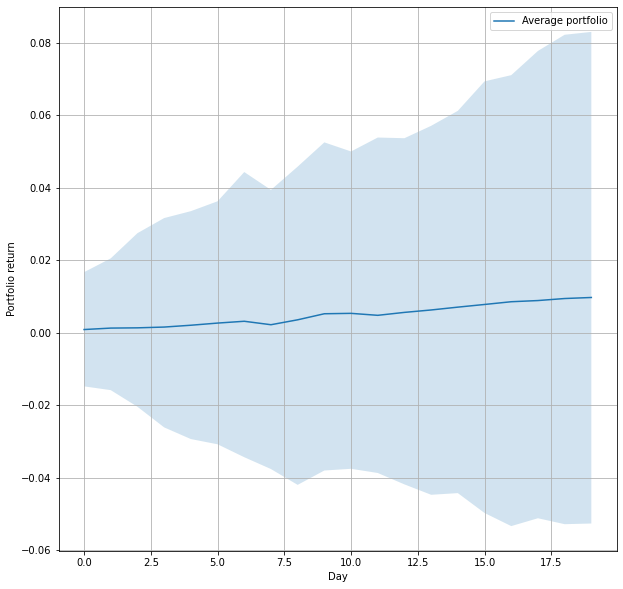

In [0]:
x = range(forecast_days)

plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(x,average_port,label="Average portfolio")
plt.xlabel("Day")
plt.ylabel("Portfolio return")


plt.fill_between(x, percentile_5th, percentile_95th,alpha=0.2)
plt.grid()
plt.legend()

plt.show()

# Probability of beating the portfolio target

In [0]:
target_return = 0.02

target_prob_port = simulated_portfolios.cumsum().apply(lambda x : np.mean(x > target_return),axis=1)

In [0]:
target_prob_port.tail(1)

19    0.38
dtype: float64

In [0]:
err_bars = np.sqrt(target_prob_port*(1-target_prob_port)/n_iterations)

In [0]:
err_bars.tail(1)

19    0.034322
dtype: float64

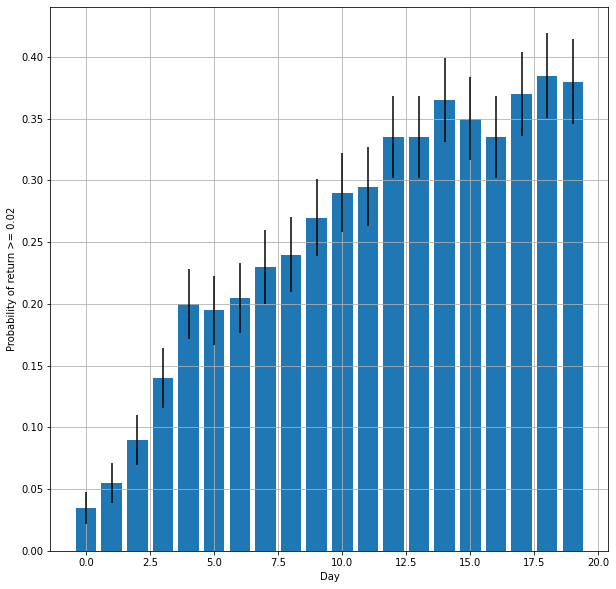

In [0]:
x = range(forecast_days)

plt.rcParams['figure.figsize'] = [10, 10]

plt.bar(x,target_prob_port,yerr = err_bars)

plt.xlabel("Day")
plt.ylabel("Probability of return >= %.2f" % (target_return))

plt.grid()

plt.show()

#Sharpe ratio histogram

In [0]:
sharpe_indices = simulated_portfolios.apply(lambda x : np.mean(x)/np.std(x))

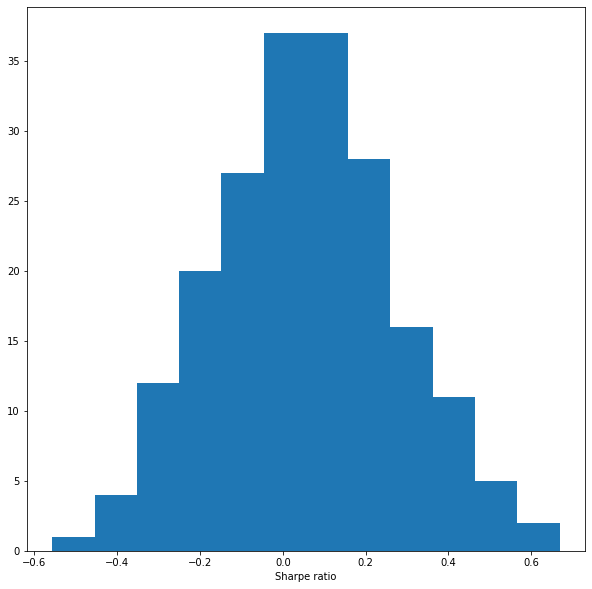

In [0]:
plt.hist(sharpe_indices,bins="rice")
plt.xlabel("Sharpe ratio")

plt.show()

# Sharpe ratio mean value

In [0]:
np.mean(sharpe_indices)

0.057974847585896196